## Импорт необходимых библиотек

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

## Конфигурация PyTorch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070


In [3]:
# Параметры модели
DATA_PATH = "dataset" # Путь датасета
BATCH_SIZE = 16 # Размер батча
EPOCHS = 10 # Количество эпох
LR = 0.001 # Learning rate
IMG_SIZE = 64 # Размер входных изображений

## Класс, описывающий датасет

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        
        self.empty_indices = []
        self.non_empty_indices = []
        
        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)
        
        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

## Аугментация данных

In [5]:
# Аугментация данных
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

## Загрузка датасета

In [6]:
# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)


Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Балансировка классов

In [7]:
# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

## Разделение на обучающую и тестовую выборку, загрузка данных

In [8]:
# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

## Функция по расчету необходимых метрик

In [9]:
# Метрики
def calculate_metrics(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()
    masks = (masks > 0.5).float()
    batch_ious, batch_dices = [], []

    for i in range(outputs.shape[0]):
        output = outputs[i]
        mask = masks[i]
        intersection = (output * mask).sum()
        union = (output + mask).sum() - intersection
        total = output.sum() + mask.sum()
        iou = (intersection / union).item() if union != 0 else float(output.sum() == 0 and mask.sum() == 0)
        dice = (2. * intersection / total).item() if total != 0 else 1.0
        batch_ious.append(iou)
        batch_dices.append(dice)

    return np.mean(batch_ious), np.mean(batch_dices)

## Модель U-net

In [10]:
# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn

class UNetSM(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNetSM, self).__init__()
        
        features = init_features
        self.encoder1 = UNetSM._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNetSM._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNetSM._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNetSM._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNetSM._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNetSM._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNetSM._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNetSM._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNetSM._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

## Обучение

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(images, masks, outputs, num_samples=3):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(images))):
        # Исходное изображение
        plt.subplot(num_samples, 3, i*3 + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        if img.shape[2] == 3:  # RGB
            plt.imshow(img)
        else:  # Grayscale
            plt.imshow(img[:, :, 0], cmap='gray')
        plt.title(f"Input Image {i+1}")
        plt.axis('off')

        # Истинная маска
        plt.subplot(num_samples, 3, i*3 + 2)
        true_mask = masks[i].cpu().squeeze().numpy()
        plt.imshow(true_mask, cmap='gray')
        plt.title(f"True Mask {i+1}")
        plt.axis('off')

        # Предсказанная маска (с пороговой бинаризацией)
        plt.subplot(num_samples, 3, i*3 + 3)
        pred_mask = torch.sigmoid(outputs[i]).gpu().squeeze().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.float32)  # Порог 0.5
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [12]:

model = UNetSM(in_channels=3, out_channels=1)

# Создаем модель с дополнительными слоями
print(device)
modified_model = model.to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images)
            test_loss += criterion(outputs, masks).item()
            
            batch_iou, batch_dice = calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "u-net.pth")
        print(f"Best modified_model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")



cuda
Epoch 1/10
Train Loss: 0.8741 | Test Loss: 0.8593
IoU: 0.7752 | Dice: 0.7752
------------------------
Best modified_model saved at epoch 1 with IoU: 0.7752
Epoch 2/10
Train Loss: 0.8602 | Test Loss: 0.8529
IoU: 0.7752 | Dice: 0.7752
------------------------
Epoch 3/10
Train Loss: 0.8583 | Test Loss: 0.8585
IoU: 0.7752 | Dice: 0.7752
------------------------
Epoch 4/10
Train Loss: 0.8584 | Test Loss: 0.8549
IoU: 0.7752 | Dice: 0.7752
------------------------
Epoch 5/10
Train Loss: 0.8573 | Test Loss: 0.8549
IoU: 0.7504 | Dice: 0.7524
------------------------
Epoch 6/10
Train Loss: 0.8573 | Test Loss: 0.8541
IoU: 0.7335 | Dice: 0.7423
------------------------
Epoch 7/10
Train Loss: 0.8565 | Test Loss: 0.8528
IoU: 0.7256 | Dice: 0.7346
------------------------
Epoch 8/10
Train Loss: 0.8564 | Test Loss: 0.8529
IoU: 0.7249 | Dice: 0.7351
------------------------
Epoch 9/10
Train Loss: 0.8571 | Test Loss: 0.8524
IoU: 0.7224 | Dice: 0.7328
------------------------
Epoch 10/10
Train Loss:

## Графики

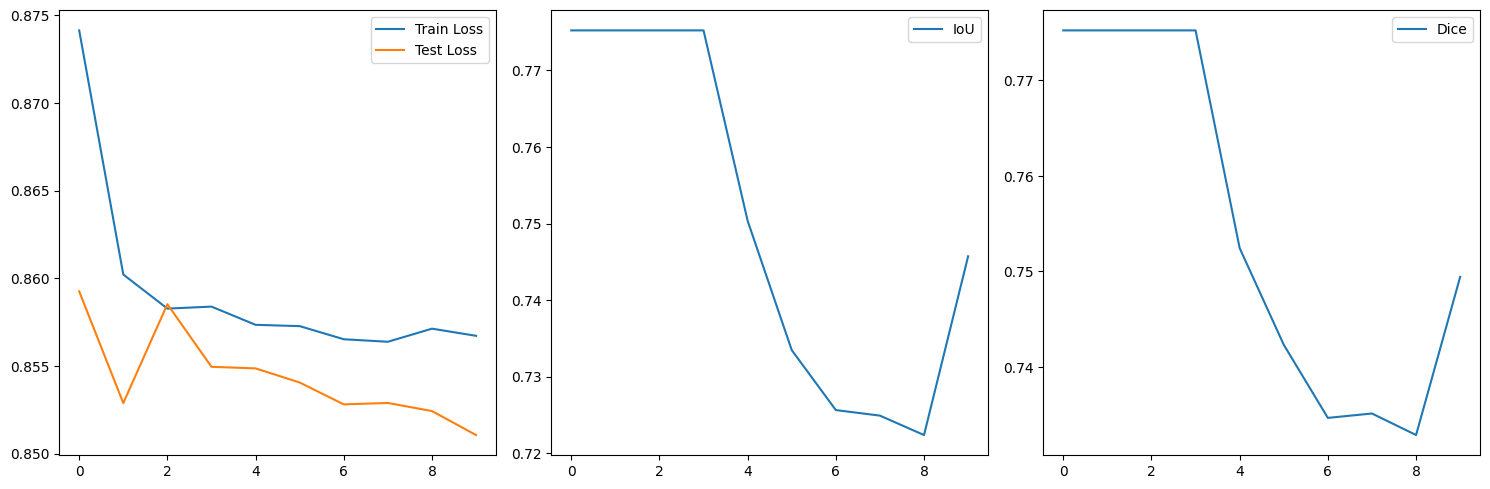

In [13]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()